In [34]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [35]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# do t-test
from scipy.stats import ttest_ind

from SSMuLA.fitness_process_vis import parse_lib_stat
from SSMuLA.de_simulations import DE_COLORS, DE_TYPES, DE_LEGEND_MAP
from SSMuLA.landscape_global import LIB_INFO_DICT
from SSMuLA.vis import PRESENTATION_PALETTE_SATURATE, LIB_COLORS
from SSMuLA.alde_analysis import avg_alde_df
from SSMuLA.zs_analysis import (
    ZS_OPTS,
    ZS_COMB_OPTS,
    ZS_OPTS_LEGEND,
)
from SSMuLA.vis_summary import (
    ZS_OPTS_APPENDED,
    ZS_COLOR_MAP_APPENDED
)

%matplotlib inline

In [37]:
five_zs = {
    "none": PRESENTATION_PALETTE_SATURATE["gray"],
    "ed_score": PRESENTATION_PALETTE_SATURATE["blue"],
    "Triad_score": PRESENTATION_PALETTE_SATURATE["orange"],
    "ev_score": PRESENTATION_PALETTE_SATURATE["green"],
    "esm_score": PRESENTATION_PALETTE_SATURATE["purple"],
    "esmif_score": PRESENTATION_PALETTE_SATURATE["yellow"],
    "coves_score": PRESENTATION_PALETTE_SATURATE["brown"],
}

triad_colors = {
    "Triad-esm_score": PRESENTATION_PALETTE_SATURATE["purple"],
    "Triad-ev_score": PRESENTATION_PALETTE_SATURATE["green"],
    "Triad_score": PRESENTATION_PALETTE_SATURATE["blue"],
    "struc-comb_score": PRESENTATION_PALETTE_SATURATE["yellow"],
}


In [38]:
def get_mlde_avg_df(mlde_all, n_sample, n_top, n_mut_cutoff, zs, active_lib_list):
    avg_mlde = mlde_all[
        (mlde_all["lib"].isin(active_lib_list))
        & (mlde_all["zs"].isin(zs))
        & (mlde_all["n_top"] == n_top)
        & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
        & (mlde_all["n_sample"].isin(n_sample))
        & (mlde_all["rep"].isin(np.arange(50)))
        & (mlde_all["model"] == "boosting")
    ][["zs", "lib", "n_sample", "top_maxes", "if_truemaxs"]].groupby(["zs", "lib", "n_sample"]).agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    # avg_mlde = avg_mlde.rename(columns={'n_sample_': 'n_sample'}).set_index("n_sample")
    return avg_mlde

In [39]:
def avg_lib(mlde_all, n_sample, ifzsoret, zsoret, active_lib_list):

    avg_mlde = mlde_all[
            (mlde_all["lib"].isin(active_lib_list))
            & (mlde_all[ifzsoret].isin(zsoret))
            # & (mlde_all["n_top"] == n_top)
            # & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
            & (mlde_all["n_sample"].isin(n_sample))
        ][[ifzsoret, "n_sample", "top_maxes_mean", "if_truemaxs_mean"]].groupby([ifzsoret, "n_sample"]).agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    return avg_mlde

In [40]:
# ft only 12.5
def get_mlde_avg_sdf(mlde_all, n_top, n_sample, n_mut_cutoff, zs, active_lib_list, ft_frac = 0.125, keeplibzs=True):

    if isinstance(zs, str):
        zs = [zs]

    slice_mlde = mlde_all[
        (mlde_all["lib"].isin(active_lib_list))
        & (mlde_all["zs"].isin(zs))
        & (mlde_all["n_top"] == n_top)
        & (mlde_all["n_sample"].isin(n_sample))
        & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
        & (mlde_all["rep"].isin(np.arange(50)))
        & (mlde_all["model"] == "boosting")
    ]

    zs_dfs = []

    for z in zs:
        zs_df = slice_mlde[slice_mlde["zs"] == z].copy()

        if z != "none":
            lib_dfs = []
            for lib in active_lib_list:
                lib_df = zs_df[zs_df["lib"] == lib].copy()
                lib_df["ft_lib_size"] = lib_df["ft_lib"].map(
                    {
                        numb: frac
                        for numb, frac in zip(
                            sorted(lib_df["ft_lib"].unique()), FTLIB_FRAC_LIST
                        )
                    }
                )
                lib_dfs.append(lib_df[lib_df["ft_lib_size"] == ft_frac])
            zs_df = pd.concat(lib_dfs)
        zs_dfs.append(zs_df)
    
    zs_df = pd.concat(zs_dfs)
    
    if keeplibzs:
        add_common = ["zs", "lib"]
    else:
        add_common = []
    
    avg_mlde = zs_df[add_common+["n_sample", "top_maxes", "if_truemaxs"]].groupby(add_common+["n_sample"]).agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    avg_mlde = avg_mlde.rename(columns={'n_sample_': 'n_sample'}).set_index("n_sample")
    return avg_mlde

In [41]:
N_SAMPLE_LIST = [24, 48, 96, 192, 288, 384, 480, 576, 960, 1920]
FTLIB_FRAC_LIST = [0.125, 0.25, 0.5, 1]
mlde_all = pd.read_csv("results/mlde/all_df_comb_onehot_3.csv")
de_all = pd.read_csv("results/de/DE-active/scale2max/all_landscape_de_summary.csv")
lib_stat  = pd.read_csv("results/corr_3_all/384/boosting-top96/actcut-1/merge_all.csv")
active_cutoff = 1
active_lib_list = lib_stat[(lib_stat["percent_active"]>=active_cutoff)]["lib"].tolist() #  & (lib_stat["percent_measured"] >= 90)

In [42]:
mlde_color_list = ["yellow", "orange", "blue", "green", "purple", "brown"]
more_colors = (
    ["#000000"]
    + [PRESENTATION_PALETTE_SATURATE[c] for c in mlde_color_list]
    + list(ZS_COLOR_MAP_APPENDED.values())[5:9]
    + [
        PRESENTATION_PALETTE_SATURATE["red"],
        PRESENTATION_PALETTE_SATURATE["light_orange"],
        PRESENTATION_PALETTE_SATURATE["light_brown"],
        PRESENTATION_PALETTE_SATURATE["gray"],
        PRESENTATION_PALETTE_SATURATE["light_gray"],
    ]
)

In [43]:
dsdf_mlde_df = (
    get_mlde_avg_sdf(
        mlde_all,
        # n_sample=[96, 384],
        n_sample=N_SAMPLE_LIST,
        n_top=96,
        n_mut_cutoff="double",
        zs=ZS_OPTS,
        active_lib_list=active_lib_list,
    )
)

dsdf_mlde_df["ZS_ensemble"] = dsdf_mlde_df["zs_"].map(lambda x: "Hamming distance +" if x in ZS_OPTS else "Simple")
dsdf_mlde_df


,zs_,lib_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
n_sample,,,,,,,
24,Triad_score,DHFR,0.354944,0.170527,0.0,0.0,Hamming distance +
48,Triad_score,DHFR,0.343727,0.057741,0.0,0.0,Hamming distance +
96,Triad_score,DHFR,0.340497,0.000122,0.0,0.0,Hamming distance +
192,Triad_score,DHFR,0.340514,0.000000,0.0,0.0,Hamming distance +
288,Triad_score,DHFR,0.340514,0.000000,0.0,0.0,Hamming distance +
...,...,...,...,...,...,...,...
384,ev_score,TrpB4,0.804453,0.066704,0.0,0.0,Hamming distance +
480,ev_score,TrpB4,0.804453,0.066704,0.0,0.0,Hamming distance +
576,ev_score,TrpB4,0.804453,0.066704,0.0,0.0,Hamming distance +


In [44]:
ds_mlde_df = (
    get_mlde_avg_sdf(
        mlde_all,
        # n_sample=[96, 384],
        n_sample=N_SAMPLE_LIST,
        n_top=96,
        n_mut_cutoff="double",
        zs=["none"],
        active_lib_list=active_lib_list,
    )
)
ds_mlde_df["ZS_ensemble"] = ds_mlde_df["zs_"].map(lambda x: "Hamming distance +" if (x in ZS_OPTS and x != "ed_score") else "Hamming distance")
ds_mlde_df["zs_"] = "ed_score"
ds_mlde_df

,zs_,lib_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
n_sample,,,,,,,
24,ed_score,DHFR,0.875114,0.078956,0.08,0.274048,Hamming distance
48,ed_score,DHFR,0.916270,0.064582,0.14,0.350510,Hamming distance
96,ed_score,DHFR,0.950912,0.058169,0.26,0.443087,Hamming distance
192,ed_score,DHFR,0.985245,0.032342,0.58,0.498569,Hamming distance
288,ed_score,DHFR,0.987788,0.029193,0.58,0.498569,Hamming distance
...,...,...,...,...,...,...,...
384,ed_score,TrpB4,0.816387,0.100194,0.12,0.328261,Hamming distance
480,ed_score,TrpB4,0.796260,0.083630,0.08,0.274048,Hamming distance
576,ed_score,TrpB4,0.805600,0.078793,0.04,0.197949,Hamming distance


In [45]:
full_mlde_df = get_mlde_avg_sdf(
    mlde_all,
    # n_sample=[96, 384],
    n_sample=N_SAMPLE_LIST,
    n_top=96,
    n_mut_cutoff="all",
    zs=["none"] + ZS_OPTS + ["Triad-esm_score", "Triad-ev_score", "struc-comb_score"],
    active_lib_list=active_lib_list,
)

full_mlde_df["ZS_ensemble"] = full_mlde_df["zs_"].map(
    lambda x: "Random"
    if x == "none"
    else (
        "Triad"
        if x == "Triad_score"
        else (
            "Simple" if (x in ZS_OPTS + ["none"] and x != "Triad_score") else "Triad +"
        )
    )
)
full_mlde_df

,zs_,lib_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
n_sample,,,,,,,
24,Triad-esm_score,DHFR,0.885188,0.144348,0.12,0.328261,Triad +
48,Triad-esm_score,DHFR,0.936586,0.071158,0.26,0.443087,Triad +
96,Triad-esm_score,DHFR,0.952664,0.054077,0.20,0.404061,Triad +
192,Triad-esm_score,DHFR,0.983864,0.032674,0.44,0.501427,Triad +
288,Triad-esm_score,DHFR,0.987981,0.031889,0.66,0.478518,Triad +
...,...,...,...,...,...,...,...
384,struc-comb_score,TrpB4,0.800048,0.086576,0.04,0.197949,Triad +
480,struc-comb_score,TrpB4,0.799725,0.081961,0.04,0.197949,Triad +
576,struc-comb_score,TrpB4,0.802985,0.069996,0.04,0.197949,Triad +


In [46]:
merge_ens = pd.concat([full_mlde_df, ds_mlde_df, dsdf_mlde_df])
merge_ens

,zs_,lib_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
n_sample,,,,,,,
24,Triad-esm_score,DHFR,0.885188,0.144348,0.12,0.328261,Triad +
48,Triad-esm_score,DHFR,0.936586,0.071158,0.26,0.443087,Triad +
96,Triad-esm_score,DHFR,0.952664,0.054077,0.20,0.404061,Triad +
192,Triad-esm_score,DHFR,0.983864,0.032674,0.44,0.501427,Triad +
288,Triad-esm_score,DHFR,0.987981,0.031889,0.66,0.478518,Triad +
...,...,...,...,...,...,...,...
384,ev_score,TrpB4,0.804453,0.066704,0.00,0.000000,Hamming distance +
480,ev_score,TrpB4,0.804453,0.066704,0.00,0.000000,Hamming distance +
576,ev_score,TrpB4,0.804453,0.066704,0.00,0.000000,Hamming distance +


In [47]:
merge_no_ed = merge_ens[merge_ens["ZS_ensemble"].isin(["Simple", "Triad", "Random"])].copy()
merge_no_ed["color"] = merge_no_ed["zs_"].map(lambda x: five_zs[x])
merge_no_ed["Ensemble type"] = "No Hamming distance"
merge_no_ed["zs_"] = pd.Categorical(merge_no_ed['zs_'], categories=list(five_zs.keys()), ordered=True)
merge_no_ed = merge_no_ed.sort_values(by=['zs_',])


merge_w_df = merge_ens[
    merge_ens["ZS_ensemble"].isin(["Hamming distance +", "Hamming distance"])
].copy()
merge_w_df["color"] = merge_w_df["zs_"].map(lambda x: five_zs[x])
merge_w_df["Ensemble type"] = "With Hamming distance"
merge_w_df["zs_"] = pd.Categorical(merge_w_df['zs_'], categories=list(five_zs.keys()), ordered=True)
merge_w_df = merge_w_df.sort_values(by=['zs_',])


merge_no_td = merge_ens[
    merge_ens["ZS_ensemble"].isin(["Simple", "Hamming distance", "Random"])
].copy()
merge_no_td["color"] = merge_no_td["zs_"].map(lambda x: five_zs[x])
merge_no_td["Ensemble type"] = "No Triad"
merge_no_td["zs_"] = pd.Categorical(merge_no_td['zs_'], categories=list(five_zs.keys()), ordered=True)
merge_no_td = merge_no_td.sort_values(by=['zs_',])


merge_w_td = pd.concat(
    [
        merge_ens[merge_ens["ZS_ensemble"].isin(["Triad", "Triad +"])],
        merge_ens[
            (merge_ens["ZS_ensemble"] == "Hamming distance +")
            & (merge_ens["zs_"] == "Triad_score")
        ],
    ]
).copy()
merge_w_td["color"] = merge_w_td["zs_"].map(lambda x: triad_colors[x])
merge_w_td["Ensemble type"] = "With Triad"
merge_w_td["zs_"] = pd.Categorical(merge_w_td['zs_'], categories=list(triad_colors.keys()), ordered=True)
merge_w_td = merge_w_td.sort_values(by=['zs_',])


all_slice_merge = pd.concat([merge_no_ed, merge_w_df, merge_no_td, merge_w_td]).reset_index()
all_slice_merge = all_slice_merge.rename(columns={"zs_": "zs", "lib_": "lib", "n_sample_": "n_sample"})
all_slice_merge

,n_sample,zs,lib,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble,color,Ensemble type
0,1920,none,TrpB4,0.875958,0.092459,0.14,0.350510,Random,#666666,No Hamming distance
1,48,none,ParD3,0.982675,0.026348,0.20,0.404061,Random,#666666,No Hamming distance
2,96,none,ParD3,0.988214,0.005244,0.14,0.350510,Random,#666666,No Hamming distance
3,192,none,ParD3,0.988234,0.004434,0.10,0.303046,Random,#666666,No Hamming distance
4,288,none,ParD3,0.989877,0.005351,0.20,0.404061,Random,#666666,No Hamming distance
...,...,...,...,...,...,...,...,...,...,...
2695,96,struc-comb_score,TrpB3G,0.882616,0.132336,0.52,0.504672,Triad +,#f9be00,With Triad
2696,192,struc-comb_score,TrpB3G,0.953998,0.084943,0.76,0.431419,Triad +,#f9be00,With Triad
2697,288,struc-comb_score,TrpB3G,0.961631,0.072980,0.78,0.418452,Triad +,#f9be00,With Triad
2698,288,struc-comb_score,TrpB3F,1.000000,0.000000,1.00,0.000000,Triad +,#f9be00,With Triad


In [48]:
all_slice_merge.zs.unique()

array(['none', 'Triad_score', 'ev_score', 'esm_score', 'esmif_score',
       'coves_score', 'ed_score', 'Triad-esm_score', 'Triad-ev_score',
       'struc-comb_score'], dtype=object)

In [49]:
avg_mlde_df_dict = {
    "Random": avg_lib(all_slice_merge, N_SAMPLE_LIST, "zs", ["none"], active_lib_list),
}

for zs in ZS_OPTS:
    avg_mlde_df_dict[f"ftMLDE: {ZS_OPTS_LEGEND[zs]}"] = avg_lib(
        all_slice_merge, N_SAMPLE_LIST, "zs", [zs], active_lib_list=active_lib_list
    )

for et in all_slice_merge["Ensemble type"].unique():
    avg_mlde_df_dict[et] = avg_lib(
        all_slice_merge, N_SAMPLE_LIST, "Ensemble type", [et], active_lib_list
    )

for zs, n in zip(
    ["ev_score", "esmif_score"],
    ["EVmutation + Hamming distance", "ESM-IF + Hamming distance"],
):

    df = (
        all_slice_merge[
            (all_slice_merge["zs"] == zs)
            & (all_slice_merge["Ensemble type"] == "With Hamming distance")
        ][["n_sample", "top_maxes_mean", "if_truemaxs_mean"]]
        .groupby(["n_sample"])
        .agg(["mean", "std"])
        .reset_index()
    )
    df.columns = ["{}_{}".format(i, j) for i, j in df.columns]

    avg_mlde_df_dict[n] = df

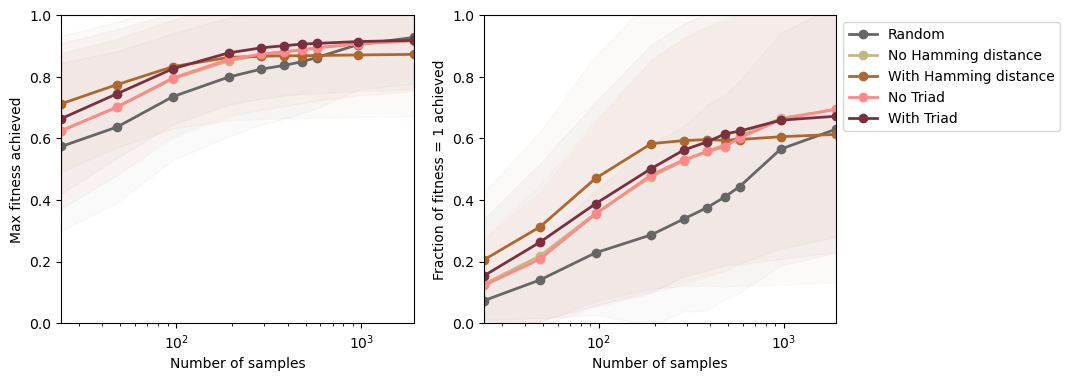

In [50]:
# sup

n_top=96

for et in all_slice_merge["Ensemble type"].unique():
    avg_mlde_df_dict[et]= avg_lib(all_slice_merge, N_SAMPLE_LIST, "Ensemble type", [et], active_lib_list)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mlde_color_list = ["gray", "light_brown", "brown", "red", "maroon"]

for ax, mlde_metric, de_metric, y_label in zip(
    axes,
    ["top_maxes", "if_truemaxs"],
    ["mean_all", "fraction_max"],
    ["Max fitness", "Fraction of fitness = 1"],
):

    for i, mlde_opts in enumerate(["Random"] + list(all_slice_merge["Ensemble type"].unique())):

        mlde_df = avg_mlde_df_dict[mlde_opts]

        ax.plot(
            mlde_df["n_sample_"],
            mlde_df[f"{mlde_metric}_mean_mean"],
            label=mlde_opts,
            marker="o",
            linestyle="solid",
            linewidth=2,
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
        )
        ax.fill_between(
            mlde_df["n_sample_"],
            mlde_df[f"{mlde_metric}_mean_mean"] - mlde_df[f"{mlde_metric}_mean_std"],
            mlde_df[f"{mlde_metric}_mean_mean"] + mlde_df[f"{mlde_metric}_mean_std"],
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
            alpha=0.03,
        )

    # for de in DE_TYPES:
    #     ax.axhline(
    #         de_avg.loc[de, f"{de_metric}_mean"],
    #         label=f"DE: {DE_LEGEND_MAP[de]}",
    #         color=DE_COLORS[de],
    #         linestyle="dashed",
    #         linewidth=2,
    #     )
    #     ax.fill_between(
    #         N_SAMPLE_LIST,
    #         de_avg.loc[de, f"{de_metric}_mean"] - de_avg.loc[de, f"{de_metric}_std"],
    #         de_avg.loc[de, f"{de_metric}_mean"] + de_avg.loc[de, f"{de_metric}_std"],
    #         color=DE_COLORS[de],
    #         alpha=0.03,
    #     )

    ax.set_xlim(N_SAMPLE_LIST[0], N_SAMPLE_LIST[-1])
    ax.set_ylim(0, 1.0)

    ax.set_xscale("log")
    ax.set_xlabel("Number of samples")
    ax.set_ylabel(f"{y_label} achieved")

    if ax == axes[1]:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

# fig.suptitle(
#     "(ft)MLDE Performance Across 10 Minimally Active Landscapes",
#     fontsize=12,
#     fontweight="bold",
#     y=0.95,
# )

In [51]:
PRESENTATION_PALETTE_SATURATE["black"] = "#000000"

In [52]:
len(more_colors)

16

Text(0.5, 0.95, '(ft)MLDE Performance Across 10 Minimally Active Landscapes')

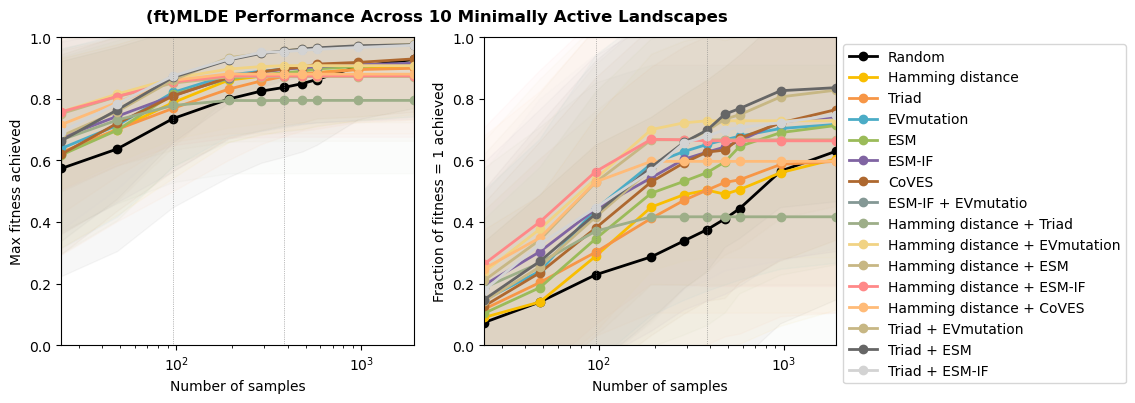

In [53]:
avg_mlde_df_dict = {
    "Random": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["none"], active_lib_list, keeplibzs=False),
    "Hamming distance": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "double", ["none"], active_lib_list, keeplibzs=False),
    "Triad": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["Triad_score"], active_lib_list, keeplibzs=False),
    "EVmutation": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["ev_score"], active_lib_list, keeplibzs=False),
    "ESM": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["esm_score"], active_lib_list, keeplibzs=False),
    "ESM-IF": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["esmif_score"], active_lib_list, keeplibzs=False),
    "CoVES": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["coves_score"], active_lib_list, keeplibzs=False),
    "ESM-IF + EVmutatio": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["two-best_score"], active_lib_list, keeplibzs=False),
    "Hamming distance + Triad": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "double", ["Triad_score"], active_lib_list, keeplibzs=False),
    "Hamming distance + EVmutation": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "double", ["ev_score"], active_lib_list, keeplibzs=False),
    "Hamming distance + ESM": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "double", ["esm_score"], active_lib_list, keeplibzs=False),
    "Hamming distance + ESM-IF": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "double", ["esmif_score"], active_lib_list, keeplibzs=False),
    "Hamming distance + CoVES": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "double", ["coves_score"], active_lib_list, keeplibzs=False),
    "Triad + EVmutation": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["Triad-ev_score"], active_lib_list, keeplibzs=False),
    "Triad + ESM": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["Triad-esm_score"], active_lib_list, keeplibzs=False),
    "Triad + ESM-IF": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["struc-comb_score"], active_lib_list, keeplibzs=False),
    # "Avg ftMLDE": ((get_mlde_avg_sdf(mlde_all, 96, "all", ZS_OPTS[1:], active_lib_list)*len(ZS_OPTS[1:]) + get_mlde_avg_sdf(mlde_all, 96, "double", ["none"], active_lib_list)))/(len(ZS_OPTS[1:])+1),
    # "Avg ftMLDE + Hamming ditance": get_mlde_avg_sdf(mlde_all, 96, "double", ZS_OPTS[1:], active_lib_list),
    # "Avg ftMLDE + Triad": (get_mlde_avg_sdf(mlde_all, 96, "all", ["Triad-ev_score", "Triad-esm_score"], active_lib_list)*2 + get_mlde_avg_sdf(mlde_all, 96, "double", ["Triad_score"], active_lib_list))/3
}

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mlde_color_list = ["gray", "orange", "blue", "green", "purple", "yellow", "brown"]

for ax, mlde_metric, de_metric, y_label in zip(
    axes,
    ["top_maxes", "if_truemaxs"],
    ["mean_all", "fraction_max"],
    ["Max fitness", "Fraction of fitness = 1"],
):

    for i, (mlde_opts, mlde_df) in enumerate(avg_mlde_df_dict.items()):

        ax.plot(
            mlde_df.index,
            mlde_df[f"{mlde_metric}_mean"],
            label=mlde_opts,
            marker="o",
            linestyle="solid",
            linewidth=2,
            color=more_colors[i],
        )
        ax.fill_between(
            mlde_df.index,
            mlde_df[f"{mlde_metric}_mean"] - mlde_df[f"{mlde_metric}_std"],
            mlde_df[f"{mlde_metric}_mean"] + mlde_df[f"{mlde_metric}_std"],
            color=more_colors[i],
            alpha=0.03,
        )

    # for de in DE_TYPES:
    #     ax.axhline(
    #         de_avg.loc[de, f"{de_metric}_mean"],
    #         label=f"DE: {DE_LEGEND_MAP[de]}",
    #         color=DE_COLORS[de],
    #         linestyle="dashed",
    #         linewidth=2,
    #     )
    #     ax.fill_between(
    #         N_SAMPLE_LIST,
    #         de_avg.loc[de, f"{de_metric}_mean"] - de_avg.loc[de, f"{de_metric}_std"],
    #         de_avg.loc[de, f"{de_metric}_mean"] + de_avg.loc[de, f"{de_metric}_std"],
    #         color=DE_COLORS[de],
    #         alpha=0.03,
    #     )

    ax.set_xlim(N_SAMPLE_LIST[0], N_SAMPLE_LIST[-1])
    ax.set_ylim(0, 1.0)

    ax.set_xscale("log")
    ax.set_xlabel("Number of samples")
    ax.set_ylabel(f"{y_label} achieved")

    # add vertical lines for 96 and 384
    ax.axvline(
        96,
        linestyle="dotted",
        color="gray",
        linewidth=0.5
    )

    ax.axvline(
        384,
        linestyle="dotted",
        color="gray",
        linewidth=0.5
    )

    if ax == axes[1]:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

fig.suptitle(
    "(ft)MLDE Performance Across 10 Minimally Active Landscapes",
    fontsize=12,
    fontweight="bold",
    y=0.95,
)

In [54]:
merge_simplezs_df = pd.concat([ds_mlde_df, full_mlde_df]).rename(columns={"zs_": "zs", "lib_": "lib", "n_sample_": "n_sample"}).reset_index()
merge_simplezs_df

,n_sample,zs,lib,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
0,24,ed_score,DHFR,0.875114,0.078956,0.08,0.274048,Hamming distance
1,48,ed_score,DHFR,0.916270,0.064582,0.14,0.350510,Hamming distance
2,96,ed_score,DHFR,0.950912,0.058169,0.26,0.443087,Hamming distance
3,192,ed_score,DHFR,0.985245,0.032342,0.58,0.498569,Hamming distance
4,288,ed_score,DHFR,0.987788,0.029193,0.58,0.498569,Hamming distance
...,...,...,...,...,...,...,...,...
1135,384,struc-comb_score,TrpB4,0.800048,0.086576,0.04,0.197949,Triad +
1136,480,struc-comb_score,TrpB4,0.799725,0.081961,0.04,0.197949,Triad +
1137,576,struc-comb_score,TrpB4,0.802985,0.069996,0.04,0.197949,Triad +
1138,960,struc-comb_score,TrpB4,0.804183,0.068562,0.04,0.197949,Triad +


In [55]:
ds_mlde_df.zs_.unique(), full_mlde_df.zs_.unique()

(array(['ed_score'], dtype=object),
 array(['Triad-esm_score', 'Triad-ev_score', 'Triad_score', 'coves_score',
        'esm_score', 'esmif_score', 'ev_score', 'none', 'struc-comb_score'],
       dtype=object))

In [56]:
import colorcet as cc
import matplotlib.colors as mcolors

# Select a colorcet colormap, for example, 'fire' or 'CET_CBL1'
colormap = cc.cm['glasbey_category10']

# Extract a list of hex codes from the colormap
glasbey_category10 = [mcolors.to_hex(colormap(i)) for i in range(colormap.N)]

Hamming distance : t=0.052 and p=0.961
EVmutation : t=0.351 and p=0.738
ESM : t=0.290 and p=0.784
ESM-IF : t=0.582 and p=0.577
CoVES : t=0.342 and p=0.745
Triad : t=0.904 and p=0.397
EVmutation
Hamming
distance : t=1.445 and p=0.184
ESM-IF
Hamming
distance : t=-0.069 and p=0.949
ESM
Hamming
distance : t=0.050 and p=0.963
Hamming distance : t=-0.720 and p=0.525
EVmutation : t=-0.111 and p=0.918
ESM : t=-0.364 and p=0.740
ESM-IF : t=-0.267 and p=0.802
CoVES : t=0.217 and p=0.843
Triad : t=-0.210 and p=0.845
EVmutation
Hamming
distance : t=1.313 and p=0.219
ESM-IF
Hamming
distance : t=0.012 and p=0.991
ESM
Hamming
distance : t=0.000 and p=1.000


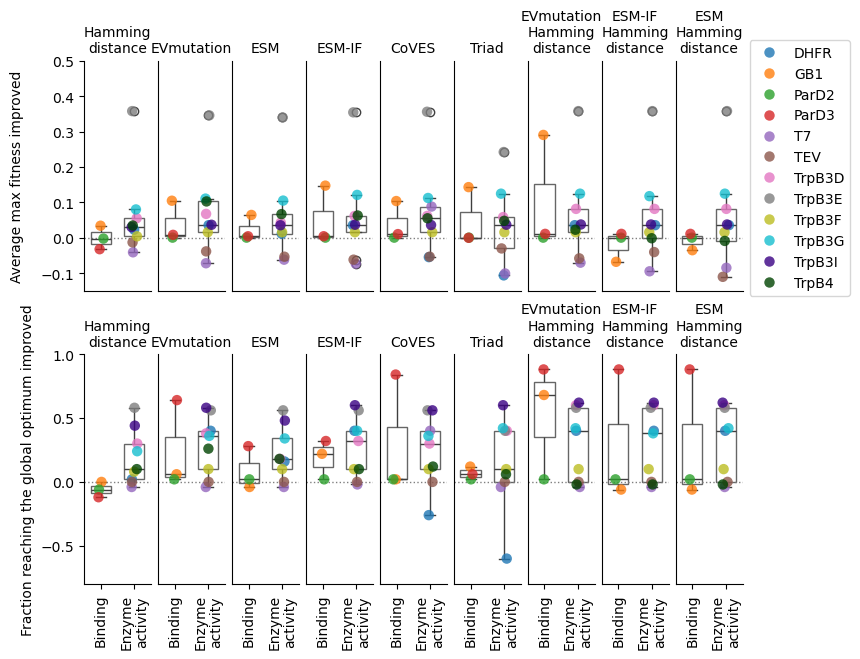

In [57]:
fig, axes = plt.subplots(2, 9, figsize=(8.4, 6.4))

n_sample = 384
slice_df = merge_simplezs_df[(merge_simplezs_df["n_sample"]==n_sample)&(merge_simplezs_df["zs"].isin(["none"] + ZS_OPTS))].copy()

# Convert 'Category' column to categorical with defined order
slice_df['zs'] = pd.Categorical(slice_df['zs'], categories=["none"] + ZS_OPTS, ordered=True)
slice_df = slice_df.sort_values(by=['zs', "lib"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["lib"].map(lambda x: LIB_INFO_DICT[x]["type"])

ens_df = all_slice_merge[all_slice_merge["n_sample"] == n_sample].sort_values(by=["lib"]).copy()
ens_merge_df = pd.concat(
    [

        ens_df[
            (ens_df["zs"] == "ev_score")
            & (ens_df["Ensemble type"] == "With Hamming distance")
        ],
        ens_df[
            (ens_df["zs"] == "esmif_score")
            & (ens_df["Ensemble type"] == "With Hamming distance")
        ],
        ens_df[
            (ens_df["zs"] == "esm_score")
            & (ens_df["Ensemble type"] == "With Hamming distance")
        ],
    ],
)
ens_merge_df["zs"] = ens_merge_df["zs"].map(
    {
        "ev_score": "EVmutation\nHamming\ndistance",
        "esmif_score": "ESM-IF\nHamming\ndistance",
        "esm_score": "ESM\nHamming\ndistance",
        # **ZS_OPTS_LEGEND,
    }
)
ens_merge_df["type"] = ens_merge_df["lib"].map(lambda x: LIB_INFO_DICT[x]["type"])


ms = ["top_maxes_mean", "if_truemaxs_mean"]
ms_dict = {'top_maxes_mean': "Average max fitness improved", "if_truemaxs_mean": "Fraction reaching the global optimum improved"}


for i in range(len(ms)):
    x = ms[i]
    rand_df = slice_df[slice_df["zs"]=="Random"][["lib", "type", x]].reset_index(drop=True).copy()

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:]) + list(ens_merge_df["zs"].unique())):
        ax = axes[i, z]
        if z<6:
            bar_type_df = slice_df[slice_df["zs"] == zs][["lib", "type", x]].reset_index(drop=True).copy()
        else:
            bar_type_df = ens_merge_df[ens_merge_df["zs"] == zs][["lib", "type", x]].reset_index(drop=True).copy()
        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["lib", "type"], how="outer")
        merg_df["delta"] = merg_df[x+"_x"] - merg_df[x+"_y"]

        sns.boxplot(
            # x="Type", y="Rho", 
            x="type", y="delta", 
            data=merg_df, 
            width=0.6, 
            ax=ax,
            order=["Binding", "Enzyme activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={'facecolor': 'None', 'edgecolor': PRESENTATION_PALETTE_SATURATE["gray"]},
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzyme activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="lib",
            hue_order=merg_df['lib'].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=glasbey_category10[:12], #sns.color_palette("tab10").as_hex() + ['#e5c494', '#a6cee3'],
            marker="o",
            alpha=0.8,
            ax=ax
        )

        labels = [label.get_text().replace('Enzyme activity', 'Enzyme\nactivity') for label in ax.get_xticklabels()]
        
        if i == 0:
            ymax = 0.5
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.15, ymax)
        else:
            ymax = 1
            ax.set_xlabel("")
            ax.set_ylim(-0.8, ymax)
            ax.set_yticks([-0.5, 0, 0.5, 1])
            ax.set_xticklabels(labels, rotation=90, ha="center")
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))
        
        if z==0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks

        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        ax.legend().remove()
        ax.set_title(zs.replace(" ", "\n"),fontdict={
            'fontsize': 10,
        })
            
        # # Hide the top and right spine
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.axhline(0, color='gray', lw=1, ls="dotted")
        
        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"]=="Binding"][x]),
            list(bar_type_df[bar_type_df["type"]=="Enzyme activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p+q)*.5, annot_y, "*", ha='center', va='bottom', color='gray')

axes[0,8].legend(loc="upper left", bbox_to_anchor=(1, 1.12))
plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)

In [60]:
alde_all = pd.read_csv("results/alde/alde_all.csv")
# Replace NaN values in column 'B' with the string "none"
alde_all['zs'] = alde_all['zs'].fillna("none")
alde_all

,n_mut_cutoff,zs,rounds,n_samples,Protein,Encoding,Model,Acquisition,Timestep,Mean,Std,Frac
0,all,none,1,120,DHFR,onehot,Boosting Ensemble,GREEDY,120,0.859808,0.024965,0.02
1,all,none,1,120,DHFR,onehot,Boosting Ensemble,TS,120,0.865163,0.022834,0.00
2,all,none,1,120,DHFR,onehot,Boosting Ensemble,UCB,120,0.842993,0.027852,0.02
3,all,none,1,120,DHFR,onehot,DKL,GREEDY,120,0.758989,0.023827,0.02
4,all,none,1,120,DHFR,onehot,DKL,TS,120,0.789997,0.021010,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
27285,double,ds-Triad,4,480,TrpB3I,onehot,DNN Ensemble,GREEDY,480,1.000000,0.000000,1.00
27286,double,ds-Triad,4,480,TrpB3I,Random,Random,GREEDY,480,0.985766,0.003312,0.06
27287,double,ds-Triad,4,480,TrpB4,onehot,Boosting Ensemble,GREEDY,480,0.811557,0.014297,0.18
27288,double,ds-Triad,4,480,TrpB4,onehot,DNN Ensemble,GREEDY,480,0.860523,0.015047,0.30


In [61]:
import colorcet as cc
import matplotlib.colors as mcolors

# Select a colorcet colormap, for example, 'fire' or 'CET_CBL1'
colormap = cc.cm['glasbey_category10']

# Extract a list of hex codes from the colormap
glasbey_category10 = [mcolors.to_hex(colormap(i)) for i in range(colormap.N)]

ed : t=0.074 and p=0.945
ev : t=0.805 and p=0.440
esm : t=0.254 and p=0.809
esmif : t=1.007 and p=0.338
coves : t=0.617 and p=0.555
Triad : t=1.449 and p=0.178
ds-esmif : t=1.244 and p=0.245
ds-ev : t=0.425 and p=0.685
ds-coves : t=0.258 and p=0.807
ed : t=-0.222 and p=0.838
ev : t=0.344 and p=0.747
esm : t=-0.150 and p=0.890
esmif : t=0.472 and p=0.657
coves : t=0.336 and p=0.756
Triad : t=0.160 and p=0.880
ds-esmif : t=1.213 and p=0.253
ds-ev : t=0.328 and p=0.759
ds-coves : t=0.319 and p=0.769


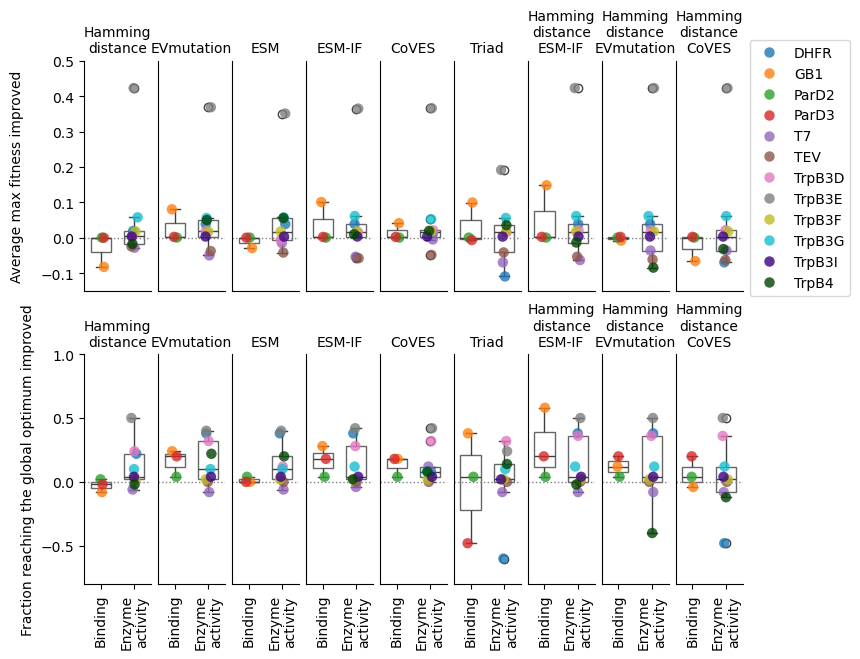

In [62]:
n_round = 4
n_sample = int((384 + 96))

slice_df = alde_all[
    (alde_all["rounds"] == n_round)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == n_sample)
    & (alde_all["Protein"].isin(active_lib_list))
].copy()

fig, axes = plt.subplots(2, 9, figsize=(8.4, 6.4))

# Convert 'Category' column to categorical with defined order
slice_df["zs"] = pd.Categorical(
    slice_df["zs"],
    categories=["none"]
    + [o.replace("_score", "") for o in ZS_OPTS]
    + [
        "ds-esmif",
        "ds-ev",
        "ds-coves",
    ],
    ordered=True,
)
slice_df = slice_df.sort_values(by=["zs", "Protein"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["Protein"].map(lambda x: LIB_INFO_DICT[x]["type"])

ms = ["Mean", "Frac"]
ms_dict = {
    "Mean": "Average max fitness improved",
    "Frac": "Fraction reaching the global optimum improved",
}

for i in range(len(ms)):
    x = ms[i]
    rand_df = (
        slice_df[slice_df["zs"] == "Random"][["Protein", "type", x]]
        .reset_index(drop=True)
        .copy()
    )

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:10])):
        ax = axes[i, z]
        bar_type_df = (
            slice_df[slice_df["zs"] == zs][["Protein", "type", x]]
            .reset_index(drop=True)
            .copy()
        )

        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["Protein", "type"], how="outer")
        merg_df["delta"] = merg_df[x + "_x"] - merg_df[x + "_y"]

        sns.boxplot(
            # x="Type", y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            width=0.6,
            ax=ax,
            order=["Binding", "Enzyme activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={
                "facecolor": "None",
                "edgecolor": PRESENTATION_PALETTE_SATURATE["gray"],
            },
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzyme activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="Protein",
            hue_order=merg_df["Protein"].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=glasbey_category10[:12], # sns.color_palette("tab10").as_hex() + ["#e5c494", "#a6cee3"],
            marker="o",
            alpha=0.8,
            ax=ax,
        )

        labels = [
            label.get_text().replace("Enzyme activity", "Enzyme\nactivity")
            for label in ax.get_xticklabels()
        ]

        if i == 0:
            ymax = 0.5
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.15, ymax)
        else:
            ymax = 1
            ax.set_xlabel("")
            ax.set_ylim(-0.8, ymax)
            ax.set_xticklabels(labels, rotation=90, ha="center")
            ax.set_yticks([-0.5, 0, 0.5, 1])
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))

        if z == 0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks

        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        if "ds-" in zs:
            ax_title = (
                "Hamming\ndistance\n" + ZS_OPTS_LEGEND[zs.replace("ds-", "") + "_score"]
            )
        else:
            ax_title = ZS_OPTS_LEGEND[zs + "_score"]
        ax.legend().remove()
        ax.set_title(
            ax_title.replace(" ", "\n"),
            fontdict={
                "fontsize": 10,
            },
        )

        # # Hide the top and right spine
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.axhline(0, color="gray", lw=1, ls="dotted")

        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"] == "Binding"][x]),
            list(bar_type_df[bar_type_df["type"] == "Enzyme activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p + q) * 0.5, annot_y, "*", ha="center", va="bottom", color="gray")

axes[0, 8].legend(loc="upper left", bbox_to_anchor=(1, 1.12))
plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)

Hamming distance : t=0.052 and p=0.961
EVmutation : t=0.351 and p=0.738
ESM : t=0.290 and p=0.784
ESM-IF : t=0.582 and p=0.577
CoVES : t=0.342 and p=0.745
Triad : t=0.904 and p=0.397
EVmutation
Hamming
distance : t=1.445 and p=0.184
ESM-IF
Hamming
distance : t=-0.069 and p=0.949
ESM
Hamming
distance : t=0.050 and p=0.963
Hamming distance : t=-0.720 and p=0.525
EVmutation : t=-0.111 and p=0.918
ESM : t=-0.364 and p=0.740
ESM-IF : t=-0.267 and p=0.802
CoVES : t=0.217 and p=0.843
Triad : t=-0.210 and p=0.845
EVmutation
Hamming
distance : t=1.313 and p=0.219
ESM-IF
Hamming
distance : t=0.012 and p=0.991
ESM
Hamming
distance : t=0.000 and p=1.000
ed : t=0.145 and p=0.892
ev : t=0.687 and p=0.512
esm : t=0.486 and p=0.647
esmif : t=0.681 and p=0.516
coves : t=0.368 and p=0.727
Triad : t=1.290 and p=0.230
ed : t=-0.196 and p=0.856
ev : t=0.210 and p=0.846
esm : t=0.252 and p=0.815
esmif : t=0.222 and p=0.837
coves : t=0.298 and p=0.784
Triad : t=-0.025 and p=0.982


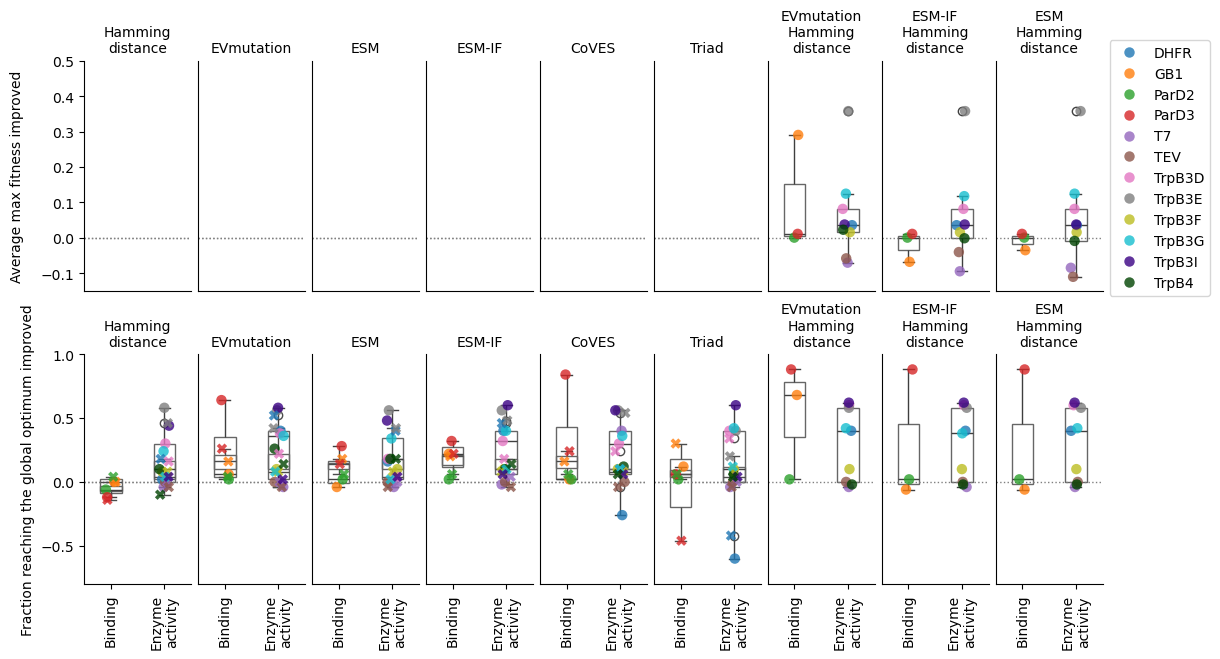

In [74]:
fig, axes = plt.subplots(2, 9, figsize=(12, 6.4))

n_sample = 384
slice_df = merge_simplezs_df[(merge_simplezs_df["n_sample"]==n_sample)&(merge_simplezs_df["zs"].isin(["none"] + ZS_OPTS))].copy()

# Convert 'Category' column to categorical with defined order
slice_df['zs'] = pd.Categorical(slice_df['zs'], categories=["none"] + ZS_OPTS, ordered=True)
slice_df = slice_df.sort_values(by=['zs', "lib"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["lib"].map(lambda x: LIB_INFO_DICT[x]["type"])

ens_df = all_slice_merge[all_slice_merge["n_sample"] == n_sample].sort_values(by=["lib"]).copy()
ens_merge_df = pd.concat(
    [

        ens_df[
            (ens_df["zs"] == "ev_score")
            & (ens_df["Ensemble type"] == "With Hamming distance")
        ],
        ens_df[
            (ens_df["zs"] == "esmif_score")
            & (ens_df["Ensemble type"] == "With Hamming distance")
        ],
        ens_df[
            (ens_df["zs"] == "esm_score")
            & (ens_df["Ensemble type"] == "With Hamming distance")
        ],
    ],
)
ens_merge_df["zs"] = ens_merge_df["zs"].map(
    {
        "ev_score": "EVmutation\nHamming\ndistance",
        "esmif_score": "ESM-IF\nHamming\ndistance",
        "esm_score": "ESM\nHamming\ndistance",
        # **ZS_OPTS_LEGEND,
    }
)
ens_merge_df["type"] = ens_merge_df["lib"].map(lambda x: LIB_INFO_DICT[x]["type"])


ms = ["top_maxes_mean", "if_truemaxs_mean"]
ms_dict = {'top_maxes_mean': "Average max fitness improved", "if_truemaxs_mean": "Fraction reaching the global optimum improved"}


for i in range(len(ms)):
    x = ms[i]
    rand_df = slice_df[slice_df["zs"]=="Random"][["lib", "type", x]].reset_index(drop=True).copy()

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:]) + list(ens_merge_df["zs"].unique())):
        ax = axes[i, z]
        if z<6:
            bar_type_df = slice_df[slice_df["zs"] == zs][["lib", "type", x]].reset_index(drop=True).copy()
        else:
            bar_type_df = ens_merge_df[ens_merge_df["zs"] == zs][["lib", "type", x]].reset_index(drop=True).copy()
        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["lib", "type"], how="outer")
        merg_df["delta"] = merg_df[x+"_x"] - merg_df[x+"_y"]

        sns.boxplot(
            # x="Type", y="Rho", 
            x="type", y="delta", 
            data=merg_df, 
            width=0.4, 
            ax=ax,
            order=["Binding", "Enzyme activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={'facecolor': 'None', 'edgecolor': PRESENTATION_PALETTE_SATURATE["gray"]},
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzyme activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="lib",
            hue_order=merg_df['lib'].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=glasbey_category10[:12], #sns.color_palette("tab10").as_hex() + ['#e5c494', '#a6cee3'],
            marker="o",
            alpha=0.8,
            ax=ax
        )

        labels = [label.get_text().replace('Enzyme activity', 'Enzyme\nactivity') for label in ax.get_xticklabels()]
        
        if i == 0:
            ymax = 0.5
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.15, ymax)
        else:
            ymax = 1
            ax.set_xlabel("")
            ax.set_ylim(-0.8, ymax)
            ax.set_yticks([-0.5, 0, 0.5, 1])
            ax.set_xticklabels(labels, rotation=90, ha="center")
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))
        
        if z==0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks

        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        ax.legend().remove()
        ax.set_title(zs.replace(" ", "\n"),fontdict={
            'fontsize': 10,
        })
            
        # # Hide the top and right spine
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.axhline(0, color='gray', lw=1, ls="dotted")
        
        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"]=="Binding"][x]),
            list(bar_type_df[bar_type_df["type"]=="Enzyme activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p+q)*.5, annot_y, "*", ha='center', va='bottom', color='gray')


x_offset = 0.15
ms = ["Mean", "Frac"]
ms_dict = {
    "Mean": "Average max fitness improved",
    "Frac": "Fraction reaching the global optimum improved",
}

slice_aldedf = alde_all[
    (alde_all["rounds"] == n_round)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == n_sample)
    & (alde_all["Protein"].isin(active_lib_list))
].copy()

# Convert 'Category' column to categorical with defined order
slice_aldedf["zs"] = pd.Categorical(
    slice_aldedf["zs"],
    categories=["none"]
    + [o.replace("_score", "") for o in ZS_OPTS]
    + [
        "ds-esmif",
        "ds-ev",
        "ds-coves",
    ],
    ordered=True,
)
slice_aldedf = slice_aldedf.sort_values(by=["zs", "Protein"])

slice_aldedf["zs"] = slice_aldedf["zs"].replace(ZS_OPTS_LEGEND)
slice_aldedf["type"] = slice_aldedf["Protein"].map(lambda x: LIB_INFO_DICT[x]["type"])


for i in range(len(ms)):
    x = ms[i]
    rand_df = (
        slice_aldedf[slice_aldedf["zs"] == "Random"][["Protein", "type", x]]
        .reset_index(drop=True)
        .copy()
    )

    for z, zs in enumerate(list(slice_aldedf["zs"].unique()[1:10])):
        ax = axes[i, z]
        bar_type_df = (
            slice_aldedf[slice_aldedf["zs"] == zs][["Protein", "type", x]]
            .reset_index(drop=True)
            .copy()
        )

        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["Protein", "type"], how="outer")
        merg_df["delta"] = merg_df[x + "_x"] - merg_df[x + "_y"]

        sns.boxplot(
            # x="Type", y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            width=0.4,
            ax=ax,
            order=["Binding", "Enzyme activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={
                "facecolor": "None",
                "edgecolor": PRESENTATION_PALETTE_SATURATE["gray"],
            },
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            # x=np.array([0 if t == "Binding" else 1 for t in merg_df["type"]]) + x_offset,  # Apply x offset for overlay,
            x = "type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzyme activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="Protein",
            hue_order=merg_df["Protein"].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=glasbey_category10[:12], # sns.color_palette("tab10").as_hex() + ["#e5c494", "#a6cee3"],
            marker="X",
            alpha=0.8,
            ax=ax,
        )

        labels = [
            label.get_text().replace("Enzyme activity", "Enzyme\nactivity")
            for label in ax.get_xticklabels()
        ]

        if i == 0:
            ymax = 0.5
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.15, ymax)
        else:
            ymax = 1
            ax.set_xlabel("")
            ax.set_ylim(-0.8, ymax)
            # ax.set_xticklabels(labels, rotation=90, ha="center")
            # ax.set_yticks([-0.5, 0, 0.5, 1])
            # label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            # label.set_position((0, 0.42))

        if z == 0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks

        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        if "ds-" in zs:
            ax_title = (
                "Hamming\ndistance\n" + ZS_OPTS_LEGEND[zs.replace("ds-", "") + "_score"]
            )
        else:
            ax_title = ZS_OPTS_LEGEND[zs + "_score"]
        ax.legend().remove()
        ax.set_title(
            ax_title.replace(" ", "\n"),
            fontdict={
                "fontsize": 10,
            },
        )

        # # Hide the top and right spine
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.axhline(0, color="gray", lw=1, ls="dotted")

        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"] == "Binding"][x]),
            list(bar_type_df[bar_type_df["type"] == "Enzyme activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p + q) * 0.5, annot_y, "*", ha="center", va="bottom", color="gray")


axes[0,8].legend(loc="upper left", bbox_to_anchor=(1, 1.12))
plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)